In [8]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
params = Table.read('line_fit_params.ecsv')

In [4]:
a, m, s = params['AMPLITUDE'], params['MEAN'], params['STDDEV']

In [5]:
for i in range(len(a)):
    if i == 0:
        lines_mod = models.Gaussian1D(a[i], m[i], s[i])
    else:
        lines_mod = lines_mod + models.Gaussian1D(a[i], m[i], s[i])

In [6]:
mw = np.arange(1000, 3000, 0.01)

(1170, 1180)

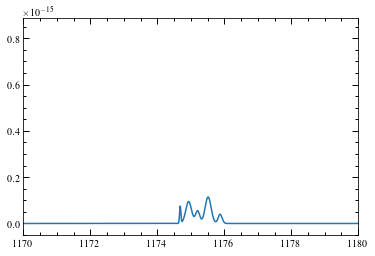

In [7]:
plt.plot(mw, lines_mod(mw))
plt.xlim(1170, 1180)

Yay!

In [127]:
hdul = fits.open('../dem/trappist-1_dem_spectra.fits')

In [128]:
hdul.info()

Filename: ../dem/trappist-1_dem_spectra.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     17   400R x 3C   [D, D, D]   


In [129]:
data = hdul[1].data

In [130]:
w, f, e = data['Wavelength'], data['Bin-Integrated Flux'], data['Error']

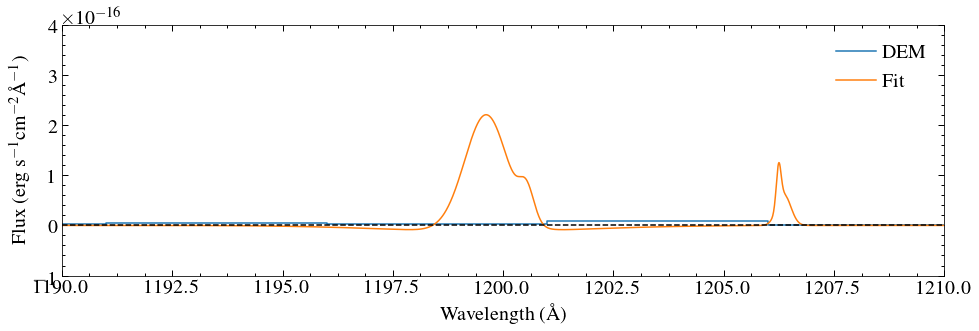

In [32]:
#plt.figure(figsize=(8,5))
plt.step(w,f/5, label = 'DEM')
plt.plot(mw, lines_mod(mw), label ='Fit')
plt.ylim(-0.1e-15, 0.4e-15)
#plt.xlim(1170.1, 1179.9)
plt.xlim(1190, 1210)
plt.legend()
plt.axhline(0, ls='--', c='k')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.tight_layout()
#plt.savefig('mod_eg.png', dpi=150)


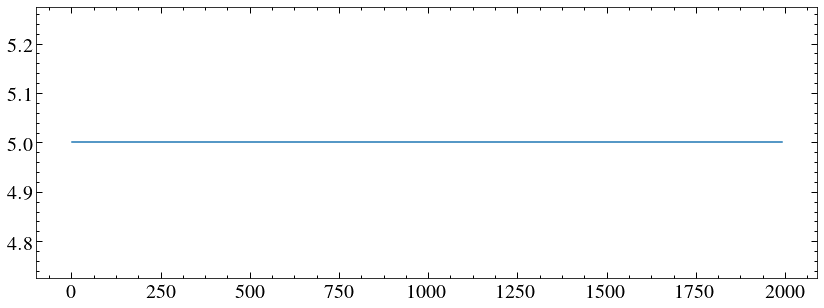

In [40]:
plt.plot(w[:-1], np.diff(w) )

In [42]:
mf = lines_mod(mw)

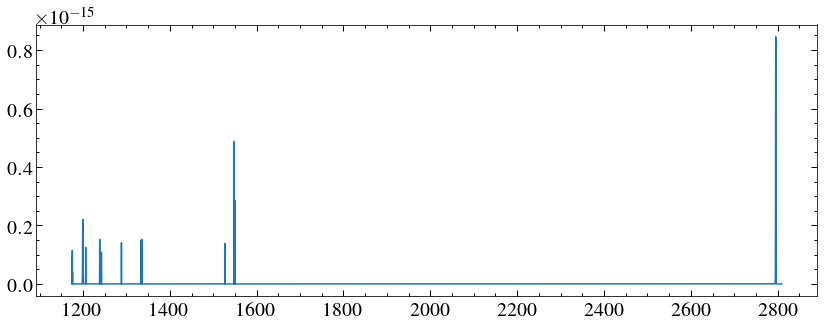

In [44]:
mask = mf >0
plt.step(mw[mask], mf[mask])

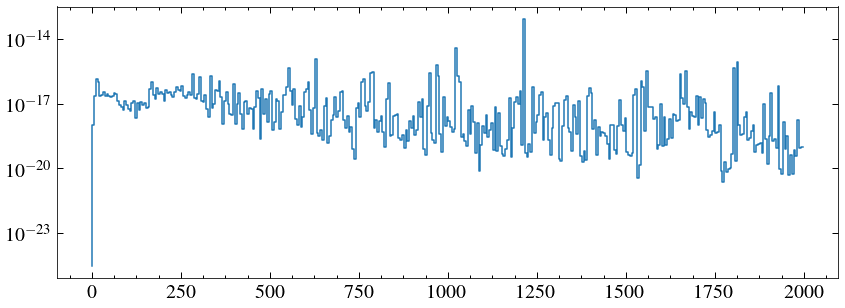

In [135]:
plt.step(w,f)
#plt.xscale('log')
plt.yscale('log')
#plt.plot(mw[mask], mf[mask])

In [70]:
mw = np.arange(w[0], w[-1], 0.01)

In [71]:
mf = lines_mod(mw)

In [72]:
#mask = (w > mw[0]) & (w< mw[-1])
#w2, f2 = w[mask], f[mask]
w2, f2 = resample.bintogrid(w,f, newx=mw)

In [73]:
mf2 = f2+mf

(1237, 1243)

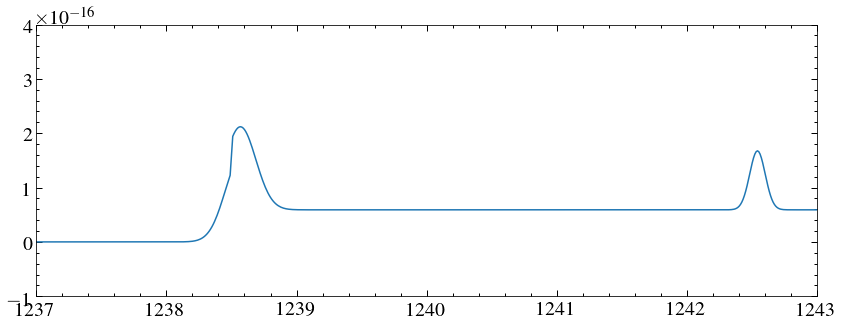

In [75]:
plt.plot(mw, mf2)
plt.ylim(-0.1e-15, 0.4e-15)
plt.xlim(1237, 1243)

Ok that's not going to work. Need to remove the lines from the DEM then add in the fitted lines.

In [22]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                  400 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'Wavelength'                                                          
TFORM1  = 'D       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'Bin-Integrated Flux'                                                 
TFORM2  = 'D       '        

In [23]:
len(w)

400

In [28]:
demf = 1.790471003124503e-17
fitf = 6.4e-17 #??

In [33]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.concatenate((np.array([diff[0]]), diff)) #adds an extra value to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1


In [34]:
w0, w1 = wavelength_edges(w)

In [96]:
line_edges = [[1174.6,1176.1],[1198.4,1200.95],[1205.9,1206.8],[1238.2,1238.9],[1242.3,1242.75],[1288.5,1288.8],[1333.9, 1334.55],[1334.9,1335.9],[1526.8, 1527.2],[1547.65, 1548.3],[1550.25,1550.75]]

In [106]:
line_width = np.diff(line_edges)

In [39]:
flux_table = Table.read('int_flux_table.ecsv')

In [139]:
fluxes = flux_table['int_flux']
#len(fluxes), len(line_edges)
fluxes *=1e-16

In [140]:
f_nl = f

In [141]:
w_all = np.concatenate((w, w0))
arg1inds = np.argsort(w_all)
w_all = w_all[arg1inds]
w_all[0:19]

array([-1.5,  1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5,
       26. , 28.5, 31. , 33.5, 36. , 38.5, 41. , 43.5])

In [142]:
changed_w = np.array([], dtype=float)
fractions = []
flux_fraction  = np.array([], dtype=float)
for edges, flux in zip(line_edges,fluxes):
    b, r = edges[0], edges[1]
    w0_b = w0[w0 < b]
    bv = np.where(w0 ==w0_b[-1])[0][0]
    w1_r= w1[w1 > r]
    rv = np.where(w1 ==w1_r[0])[0][0]
    overlap_w = np.unique([w[bv], w[rv]])
    changed_w = np.concatenate((changed_w, overlap_w))
    if len(overlap_w) == 1:
        fractions.append(1.0)
        flux_add = [flux]
    else:
        frac1 = (w1[bv] - b)/(r-b)
        frac2 = 1. - frac1
        #print(frac1, frac2)
        flux_add = [flux*frac1, flux*frac2]
    flux_fraction = np.concatenate((flux_fraction, flux_add))
    
print(changed_w)
print(flux_fraction)

[1176. 1196. 1201. 1206. 1236. 1241. 1241. 1286. 1291. 1336. 1336. 1526.
 1546. 1551.]
[6.40535023e-17 1.09388423e-17 2.68001636e-16 3.45670557e-17
 1.93955821e-17 2.58607762e-17 1.61940098e-17 0.00000000e+00
 1.38314057e-17 3.00406694e-17 5.23182725e-17 1.71800142e-17
 8.49309844e-17 4.78138368e-17]


In [143]:
f_nl = f/(w1-w0)
for i in range(len(f_nl)):
    j = 0
    if w[i] in changed_w:
        f_nl[i] = f_nl[i] - flux_fraction[j]
        j+=1
        

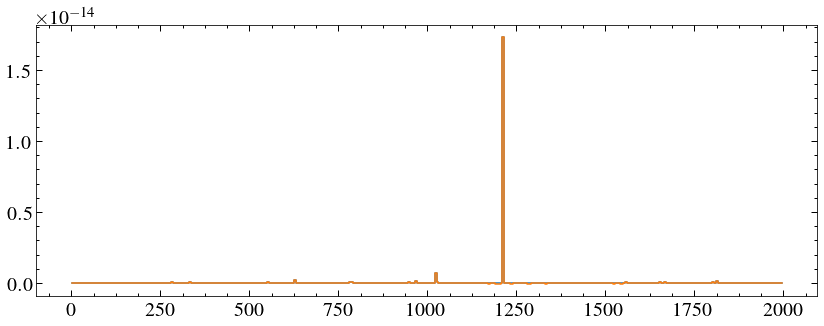

In [146]:
plt.step(w,f/(w1-w0))
plt.step(w, f_nl)
#plt.ylim(-0.1e-15, 0.4e-15)
#plt.xlim(1170.1, 1179.9)
#plt.xlim(1190, 1210)

In [152]:
w_new = np.arange(0,2000,1)

In [153]:
w_new, f_dem_new = resample.bintogrid(w, f_nl, newx=w_new)

In [154]:
f_lines = lines_mod(w_new)

In [155]:
f_new = f_dem_new + f_lines

(1190, 1210)

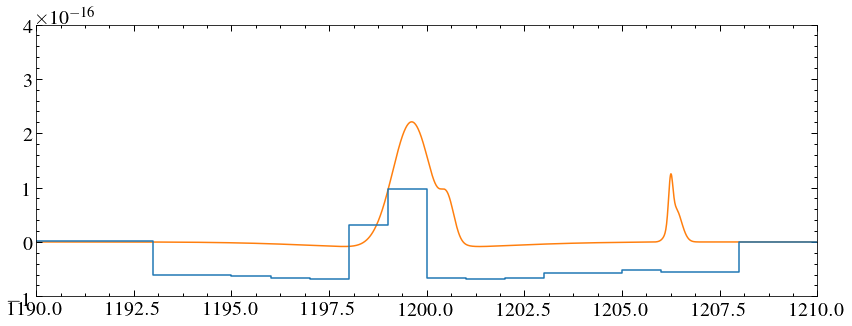

In [158]:
plt.step(w_new, f_new)
plt.plot(mw, lines_mod(mw), zorder=-1)
plt.ylim(-0.1e-15, 0.4e-15)
#plt.xlim(1170.1, 1179.9)
plt.xlim(1190, 1210)

Hasn't worked, negative values in the DEM. Replace with fit to points either side?

Brief sidetrack - how does dem compare to Linsky? - Need Lya first.

In [159]:
euv = Table.read('../combined/TRAPPIST-1_1Aeuv_estimate.ecsv')

In [160]:
linw, linf = euv['WAVELENGTH'], euv['FLUX']

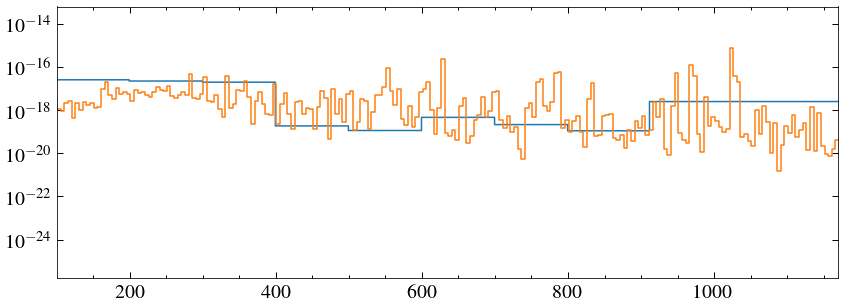

In [168]:
plt.step(linw, linf)
plt.step(w,f/(w1-w0))
plt.xlim(linw[0], linw[-1])#
#plt.ylim(, 1e-15)
plt.yscale('log')

So comparable.